# Time Series Forecasting in Python:

# Milestone 1 Objective:

* Combine, clean, and prepare the energy and temperature datasets for exploration and modeling. We will use the combined and cleaned datasets to make the exploration and modeling an easier task in the upcoming sections.

## Data Description:
* hr_temp_20170201-20200131_subset.csv – This is a dataset containing hourly (variable DATE) temperature data (variable HourlyDryBulbTemperature) at a weather station near the area you are forecasting energy for.

* hrl_load_metered - 20170201-20200131.csv – This is a dataset containing hourly (variable datetime_beginning_ept) megawatt usage data (variable mw) for the area in Pennsylvania centered around Duquesne. We are using only three years of data because we want to make sure that we look at recent energy patterns that are still applicable to our current customers.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input/milestone1'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/milestone1/hrl_load_metered - 20170201-20200131.csv
/kaggle/input/milestone1/hr_temp_20170201-20200131_subset.csv
/kaggle/input/milestone1/hr_temp_20200201-20200229_subset.csv


## 1.0 Load Data:
* First, let's make sure to import date related values with 'datetime64' data type for easy manipulation.

In [4]:
meter = pd.read_csv('/kaggle/input/milestone1/hrl_load_metered - 20170201-20200131.csv')#, parse_dates=['datetime_beginning_utc', 'datetime_beginning_ept'])
weather = pd.read_csv('/kaggle/input/milestone1/hr_temp_20170201-20200131_subset.csv', parse_dates=['DATE'])
weather1 = pd.read_csv('/kaggle/input/milestone1/hr_temp_20200201-20200229_subset.csv', parse_dates=['DATE'])

In [5]:
for column in ['datetime_beginning_utc', 'datetime_beginning_ept']:
    meter[column] = pd.to_datetime(meter[column])

weather = weather.sort_values('DATE')
meter = meter.sort_values('datetime_beginning_ept')
print(f'weather: {weather.shape}')
print(f'meter: {meter.shape}')

weather: (26280, 5)
meter: (26280, 8)


In [6]:
weather.dtypes

STATION                              int64
DATE                        datetime64[ns]
REPORT_TYPE                         object
SOURCE                               int64
HourlyDryBulbTemperature           float64
dtype: object

In [7]:
meter.dtypes

datetime_beginning_utc    datetime64[ns]
datetime_beginning_ept    datetime64[ns]
nerc_region                       object
mkt_region                        object
zone                              object
load_area                         object
mw                               float64
is_verified                         bool
dtype: object

## 2.0 Preprocessing:

### 2.1 Drop/Rename columns:
* Let's drop unnecessary columns and rename some columns for simplicity.

In [8]:
#weather
weather = weather.drop(columns=['STATION','REPORT_TYPE','SOURCE'])

In [9]:
#meter
meter = meter.rename(columns={'datetime_beginning_ept':'DATE'})
meter = meter.drop(columns=['datetime_beginning_utc','nerc_region','mkt_region','zone','load_area','is_verified'])
meter.head()

,DATE,mw
0,2017-02-01 00:00:00,1419.881
1,2017-02-01 01:00:00,1379.505
2,2017-02-01 02:00:00,1366.106
3,2017-02-01 03:00:00,1364.453
4,2017-02-01 04:00:00,1391.265


### 2.2 Index DateTime / Merge DataFrames:
* Let's create extract information (year, month, hour, day, day_of_week) from 'DATE'column.
* Then, we will create new columns for it.
* Fianlly, we will make these columns as index for each dataframe.
* This makes combining our two dataframes (energy & weather) easier using common index.

In [10]:
meter['day_of_week'] = meter.DATE.dt.dayofweek
meter['hour'] = meter.DATE.dt.hour
meter['day'] = meter.DATE.dt.day
meter['month'] = meter.DATE.dt.month
meter['year'] = meter.DATE.dt.year
meter.head(3)

,DATE,mw,day_of_week,hour,day,month,year
0,2017-02-01 00:00:00,1419.881,2,0,1,2,2017
1,2017-02-01 01:00:00,1379.505,2,1,1,2,2017
2,2017-02-01 02:00:00,1366.106,2,2,1,2,2017


In [11]:
weather['day_of_week'] = weather.DATE.dt.dayofweek
weather['hour'] = weather.DATE.dt.hour
weather['day'] = weather.DATE.dt.day
weather['month'] = weather.DATE.dt.month
weather['year'] = weather.DATE.dt.year
weather.head(3)

,DATE,HourlyDryBulbTemperature,day_of_week,hour,day,month,year
0,2017-02-01 00:53:00,37.0,2,0,1,2,2017
1,2017-02-01 01:53:00,37.0,2,1,1,2,2017
2,2017-02-01 02:53:00,36.0,2,2,1,2,2017


In [12]:
weather0 = weather.set_index(['year','month','day','hour','day_of_week'])
meter0 = meter.set_index(['year','month','day','hour','day_of_week'])

weather0 = weather0.drop(columns=['DATE'])
meter0 = meter0.drop(columns=['DATE'])
df = weather0.join(meter0, how='outer')
df = df.rename(columns={'HourlyDryBulbTemperature':'temp'})
df

temp        mw
year month day hour day_of_week                
2017 2     1   0    2            37.0  1419.881
               1    2            37.0  1379.505
               2    2            36.0  1366.106
               3    2            36.0  1364.453
               4    2            36.0  1391.265
...                               ...       ...
2020 1     31  19   4            34.0  1618.484
               20   4            33.0  1580.925
               21   4            33.0  1545.354
               22   4            33.0  1478.832
               23   4            34.0  1405.188

[26283 rows x 2 columns]

### 2.3 Identify Missing Data:
* Not all of the temperature data is recorded, as the stations would occasionally not report.
* So, we will fill in these missing values using linear interpolation.
* Let's look at what data we are mssing.

In [13]:
df.isna().sum()

temp    37
mw       3
dtype: int64

In [14]:
#missing mw values (Mar 12 2017, Mar 11 2018, Mar 10 2019)
# Sunday of 3rd week of March may be the yearly maintenance downtime for energy meter
missing_mw = df[df['mw'].isna()==True]
missing_mw

,,,,,temp,mw
year,month,day,hour,day_of_week,,
2017,3,12,2,6,17.0,NaN
2018,3,11,2,6,23.0,NaN
2019,3,10,2,6,46.0,NaN


In [15]:
# missing temp values (Oct 25 2018, Dec 25 2018, May 26 2019)
# weather temp sensor doesn't exibit any particular yearly maintenance downtime.
# we will fill this temp values with interpolation
missing_temp = df[df['temp'].isna()==True]
missing_temp

temp        mw
year month day hour day_of_week                
2018 10    25  12   3             NaN  1581.431
     12    25  2    1             NaN  1269.577
               3    1             NaN  1263.540
               4    1             NaN  1271.892
               5    1             NaN  1304.021
               6    1             NaN  1340.344
               7    1             NaN  1380.992
               8    1             NaN  1395.445
               9    1             NaN  1422.708
               10   1             NaN  1438.822
               11   1             NaN  1413.274
               12   1             NaN  1394.176
               13   1             NaN  1375.023
               14   1             NaN  1354.344
               15   1             NaN  1348.573
               16   1             NaN  1379.544
               17   1             NaN  1455.665
               18   1             NaN  1462.390
               19   1             NaN  1462.030
               20   1             NaN  1461.466
               21   1             NaN  1448.051
               22   1             NaN  1406.473
               23   1             NaN  1345.258
           26  0    2             NaN  1301.272
               1    2             NaN  1267.715
               2    2             NaN  1264.119
               3    2             NaN  1259.701
               4    2             NaN  1279.052
               5    2             NaN  1332.444
               8    2             NaN  1526.808
               9    2             NaN  1558.543
               10   2             NaN  1564.532
               11   2             NaN  1543.588
2019 5     26  1    6             NaN  1250.662
               2    6             NaN  1216.115
               3    6             NaN  1174.187
               7    6             NaN  1223.292

### 2.4 Treat Missing Data:
* we are missing:
    * 37 temperature data [temp (unit: degree F)]
    * 3 energy consumption data [mw (unit: MWh)]
* Let's use linear interpolation to fill in the gaps with forward direction.

In [16]:
df['temp'] = df['temp'].interpolate(method='linear', limit_direction = 'forward')
df['mw'] = df['mw'].interpolate(method='linear', limit_direction = 'forward')
df.isnull().sum()

temp    0
mw      0
dtype: int64

### 2.5 Re-index with Date:
* we will desolve multi-index (year, month, day, hour)
* Then, we will create a new index, 'date', which will combine all these values.

In [17]:
df = df.reset_index()
df.head(3)

,year,month,day,hour,day_of_week,temp,mw
0,2017,2,1,0,2,37.0,1419.881
1,2017,2,1,1,2,37.0,1379.505
2,2017,2,1,2,2,36.0,1366.106


In [18]:
df['date'] = pd.to_datetime(dict(year=df.year, month=df.month, day=df.day, hour=df.hour))
print(df.dtypes)
df.head(3)

year                    int64
month                   int64
day                     int64
hour                    int64
day_of_week             int64
temp                  float64
mw                    float64
date           datetime64[ns]
dtype: object


,year,month,day,hour,day_of_week,temp,mw,date
0,2017,2,1,0,2,37.0,1419.881,2017-02-01 00:00:00
1,2017,2,1,1,2,37.0,1379.505,2017-02-01 01:00:00
2,2017,2,1,2,2,36.0,1366.106,2017-02-01 02:00:00


In [19]:
df = df.set_index('date')
df = df.rename(columns={'day_of_week':'weekday'})
df.head(3)

,year,month,day,hour,weekday,temp,mw
date,,,,,,,
2017-02-01 00:00:00,2017,2,1,0,2,37.0,1419.881
2017-02-01 01:00:00,2017,2,1,1,2,37.0,1379.505
2017-02-01 02:00:00,2017,2,1,2,2,36.0,1366.106


### 2.6 Train/Test Split:
* train = from 2017-02-01 to 2019-12-31
* test = from 2020-01-01 to 2020-01-31

In [20]:
train = df[df.index.to_series().between('2017-01-01 00:00:00','2019-12-31 23:59:59') == True]
test = df[df.index.to_series().between('2020-01-01 00:00:00','2020-12-31 23:39:59') == True]

In [21]:
train

,year,month,day,hour,weekday,temp,mw
date,,,,,,,
2017-02-01 00:00:00,2017,2,1,0,2,37.0,1419.881
2017-02-01 01:00:00,2017,2,1,1,2,37.0,1379.505
2017-02-01 02:00:00,2017,2,1,2,2,36.0,1366.106
2017-02-01 03:00:00,2017,2,1,3,2,36.0,1364.453
2017-02-01 04:00:00,2017,2,1,4,2,36.0,1391.265
...,...,...,...,...,...,...,...
2019-12-31 19:00:00,2019,12,31,19,1,32.0,1606.134
2019-12-31 20:00:00,2019,12,31,20,1,32.0,1565.014
2019-12-31 21:00:00,2019,12,31,21,1,32.0,1515.905


In [22]:
test

,year,month,day,hour,weekday,temp,mw
date,,,,,,,
2020-01-01 00:00:00,2020,1,1,0,2,31.0,1363.428
2020-01-01 01:00:00,2020,1,1,1,2,29.0,1335.975
2020-01-01 02:00:00,2020,1,1,2,2,30.0,1296.817
2020-01-01 03:00:00,2020,1,1,3,2,30.0,1288.403
2020-01-01 04:00:00,2020,1,1,4,2,31.0,1292.263
...,...,...,...,...,...,...,...
2020-01-31 19:00:00,2020,1,31,19,4,34.0,1618.484
2020-01-31 20:00:00,2020,1,31,20,4,33.0,1580.925
2020-01-31 21:00:00,2020,1,31,21,4,33.0,1545.354


In [23]:
# let's confirm that we didn't miss any rows when splitting dataset to train/test
print(f'df: {df.shape[0]}')
print(f'train: {train.shape[0]}')
print(f'test: {test.shape[0]}')
print(f'train+test = df: {train.shape[0]+test.shape[0]} = {df.shape[0]}')

df: 26283
train: 25539
test: 744
train+test = df: 26283 = 26283


## Milestone 1 Remarks:
* Train (25539)/Test(744) split is successfully completed with no data loss.
* Now, we are ready to submit this assignment.

# Milestone 2 Objective: 
* Visualize the energy data we are going to model and explore the relationship between the energy data and corresponding temperature data. We will use the takeaways from these explorations to build our first model in the next section.

### Workflow:
* Plot the training energy data over time.
* It is good to look at overall patterns. 
* What generic overall patterns do you notice around the seasons of the year?

### 1.0 Overall Patterns
Let's plot the overall pattern relationship by looking at the temperature and energy consumption.

In [24]:
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl

[Text(0.5, 1.0, 'Temperature vs Energy Consumption'),
 Text(0, 0.5, '[MWh]'),
 Text(0.5, 0, '[degree F]')]

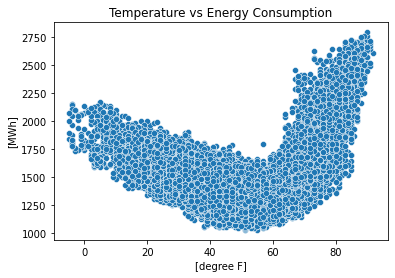

In [25]:
ax = sns.scatterplot(data=train, x='temp', y='mw')
ax.set(title='Temperature vs Energy Consumption', ylabel='[MWh]', xlabel='[degree F]')
#fig.show()

We can see that temp & mw have negative linear relationship below around 60F, and positive linear relationship above around 60F.

Now, let's looks at the trends of temperature and energy consumption over time to see how this relationship changes throughout the year.

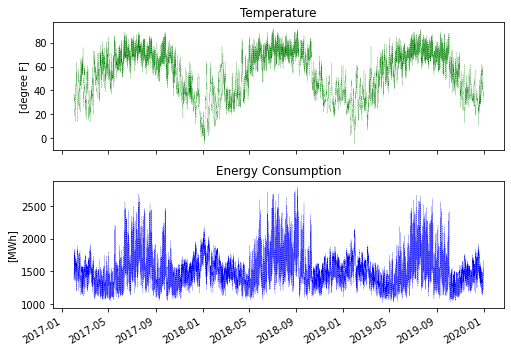

In [26]:
fig, ax = plt.subplots(2,1, figsize=(7.2,5),sharex=True)
ax[0].plot(train.index, train.temp, 'g-.', label='temp', linewidth=.2)
ax[1].plot(train.index, train.mw, 'b-.', label ='mw', linewidth=.2 )
fig.autofmt_xdate()
#ax[0].legend()
#ax[1].legend()
ax[0].set(title='Temperature', ylabel= '[degree F]')
ax[1].set(title='Energy Consumption', ylabel='[MWh]')
plt.tight_layout()

We can see the seasonal behaviour. Each year, temperature goes up during the summer and goes down during winter. Energy consumption is also cyclical. During the summer, increase of temperature correlates with increase in energy consumption. However, increase in temperature during Winter correlates with decrease in energy consumption. Let's look at monthly patterns to identify positive/negative relationship turning point between temperature and energy consumption.

### 1.1 Monthly Patterns

Across entire 2017-2019, let's look at temperature & energy consumption at each hour in each month.

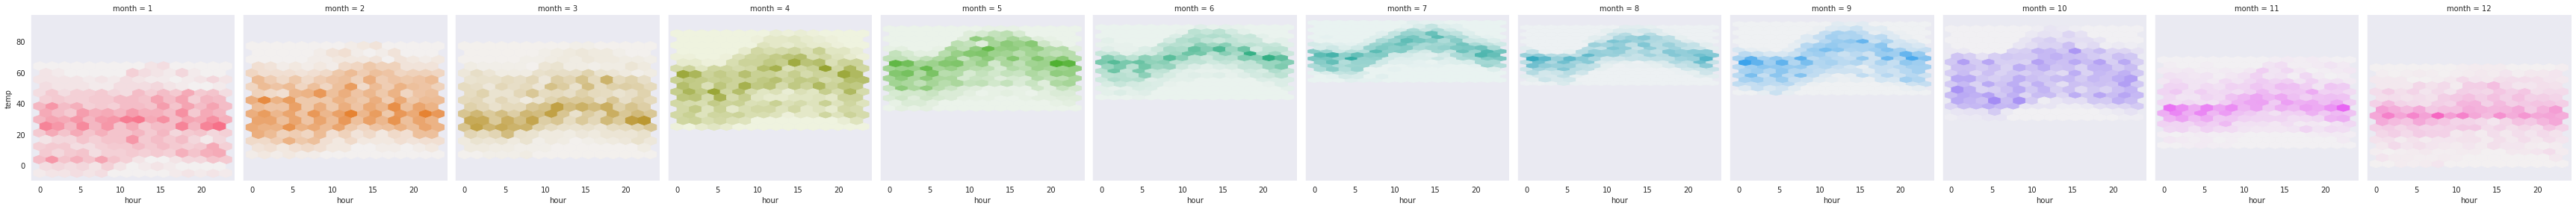

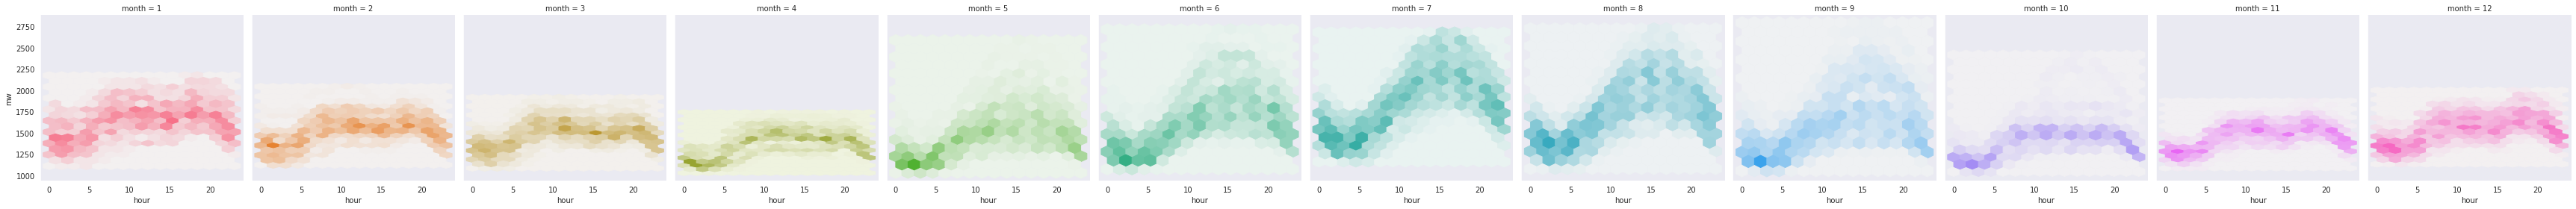

In [27]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=15, cmap=cmap, **kwargs)
    
with sns.axes_style('dark'):
    g = sns.FacetGrid(train, hue='month', col='month', height=4)
    g1 = sns.FacetGrid(train, hue='month', col='month', height=4)
    
g.map(hexbin, 'hour', 'temp')
g1.map(hexbin, 'hour', 'mw')

Let's look at monthly mean of temperature and energy consumption over time.

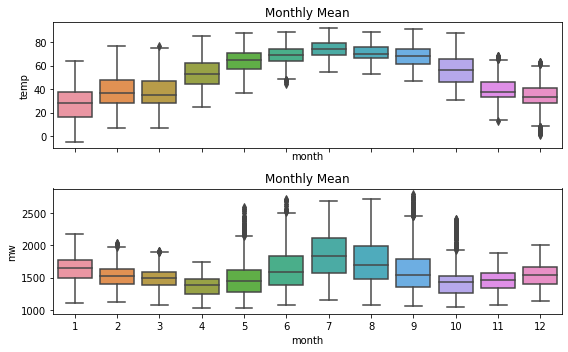

In [28]:
fig, axes = plt.subplots(2,1, figsize=(8,5), sharex=True)

for name, ax in zip(['temp', 'mw'], axes):
    sns.boxplot(x='month', y=name, data=train, ax=ax)
    ax.set(title='Monthly Mean')
    
plt.tight_layout()

From above plots, Summer months tend to have larger variation in energy consumpton while to have the smallest variation in temperture. We can suspect that every 1 degree change in temperature during the Summer has larger impact on whether people will use air conditioning or not. Some occupants are more tolerant to heat based on preference, location, and desire to save energy, etc.

Let's break down the energy consumption to each month. It will show us which month has turning point where positive temp vs mw relationship turns into negative relationship and vise versa.

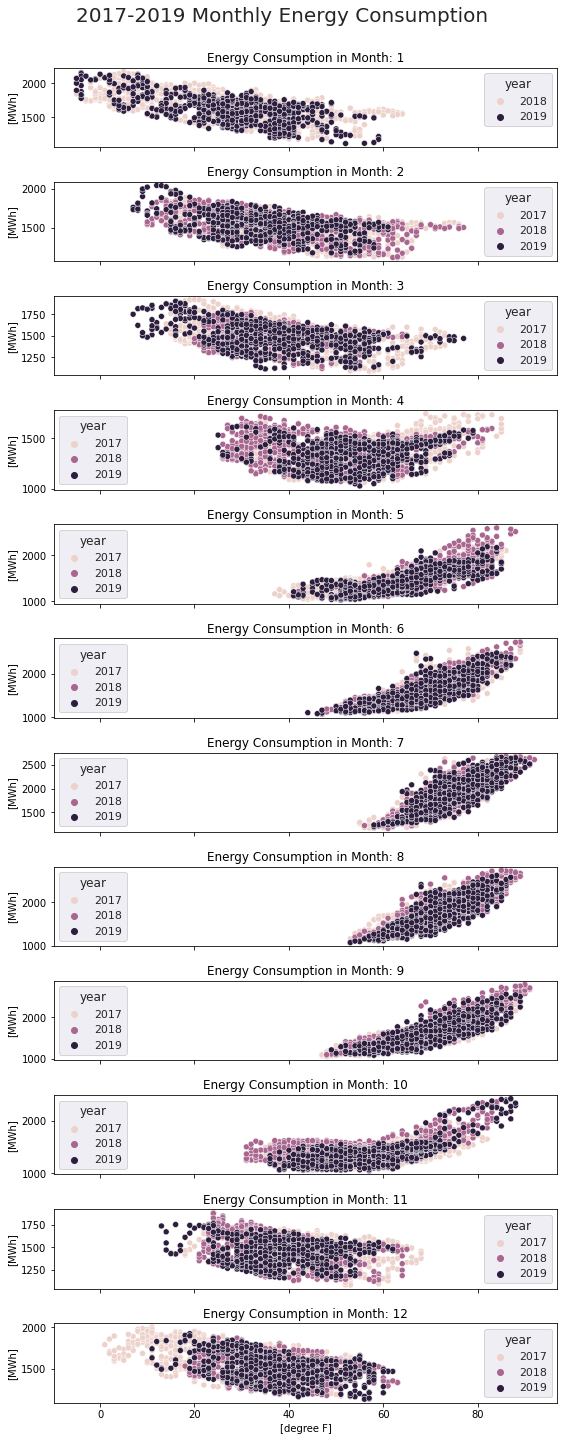

In [29]:
fig, axes = plt.subplots(12,1, figsize=(8,20), sharex=True)
sns.set(style='darkgrid')

for m, ax in zip(range(1,13), axes):
    plot = sns.scatterplot(data=train[train.month.isin([m])], x='temp', y='mw', hue='year', ax=ax)
    plot.set(title=f'Energy Consumption in Month: {m}', xlabel ='[degree F]',ylabel='[MWh]')
    #plt.legend(bbox_to_anchor=(1.05, 1.0), loc=2, borderaxespad=0., ncol=1)    

    fig.suptitle('2017-2019 Monthly Energy Consumption', fontsize=20, y=1.)
plt.tight_layout()

From above, we can see that **April & October** is the turning point of this positive/negative linear relationship between tmeparture and the energy consumption.

### 1.2 Seasonal Patterns

Let's look at the seasonal patterns:
* q1: Winter to Spring (January~April)
* q2: Spring to Summer (April~July)
* q3: Summer to Fall (July~October)
* q4: Fall to Winter (October~January)

In [30]:
train_q1 = train[train.month.isin([1,2,3,4])]
train_q2 = train[train.month.isin([4,5,6,7])]
train_q3 = train[train.month.isin([7,8,9,10])]
train_q4 = train[train.month.isin([10,11,12,1])]

#### 1.2.1 2017-2019 Q1-Q4 Correlation:

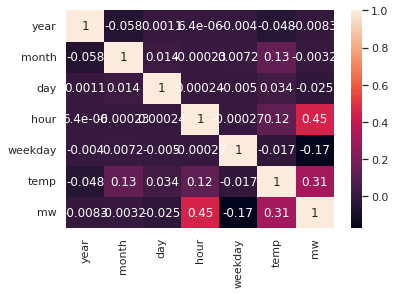

In [31]:
corr = train.corr(method='spearman')
sns.heatmap(corr, annot=True)
fig.show()

#### 1.2.2 2017-2019 Q1 Correlation:

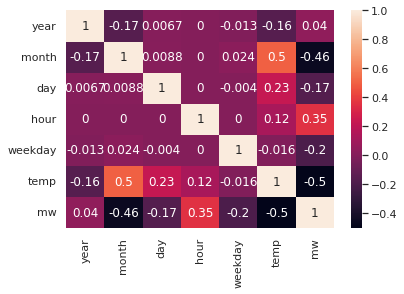

In [32]:
corr = train_q1.corr(method='spearman')
sns.heatmap(corr, annot=True )
fig.show()

#### 1.2.3 2017-2019 Q2 Correlation:

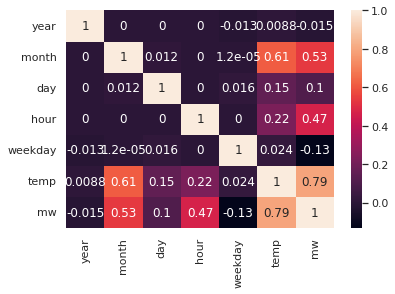

In [33]:
corr = train_q2.corr(method='spearman')
sns.heatmap(corr, annot=True )
fig.show()

#### 1.2.4 2017-2019 Q3 Correlation:

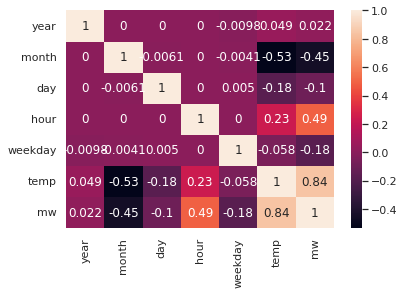

In [34]:
corr = train_q3.corr(method='spearman')
sns.heatmap(corr, annot=True )
fig.show()

#### 1.2.5 2017-2019 Q4 Correlation:

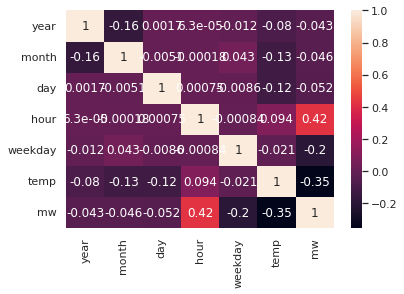

In [35]:
corr = train_q4.corr(method='spearman')
sns.heatmap(corr, annot=True )
fig.show()

#### 1.2.6 Seasonal Correlation:

* **Summer** - Very high linear relationship with temp
* **Winter** - Medium linear relationship with temp. 
    * combination of temp/month/hour linearly correlates with energy usage.

**Linear relationsihp** strength:
* q1-q4: hour(0.45) > temp(0.31) > weekday(-0.17)  
* q1: temp(-0.5) > month(-0.46) > hour(0.35)
* q2: temp(0.79) > month(0.53) > hour(0.47)
* q3: temp(0.84) > hour (0.49) > month(-0.45)
* q4: hour(0.42) > temp(-0.35) > weekday(0.2)

#### 1.2.7 Monthly Correlation:
* **March** will likely be most **difficult** to predict with a linear regression model using **temperature and hour of day**.
* **Summer** months will likely be **easy** to predict with a linear regression model using **temperature** alone.
* **January** will be likely be **not as easy** to predict with a linear regression model using **temperature and hour of day**.

However, we need to investigate relationships other than 'linear' since non-linear relationship can be a stronger predictor for this energy consumption.

Months with high linear correlation with **temp [Month: 1,5,6,7,8,9]**
* May - temp(0.77) >> hour(0.49)
* Jun - temp(0.82) >> hour(0.53)
* Jul - temp(0.84) >> hour(0.6)
* Aug - temp(0.85) >> hour(0.56)
* Sep - temp(0.85) >> hour(0.48)
* Jan - temp(0.64) >> hour(0.38)


Months with high linear correlation with **temp & hour [Month: 2,3,10,12]**
* Feb - temp(-0.47) >= hour(0.4) > day(-0.36)
* Mar - temp(-0.38) >= hour(0.37)
* Oct - temp(0.56) >= hour(0.43)
* Dec - hour(0.5) >= temp(-0.44)


Months with high linear correlation with **Hour [Month: 4,11]**
* Apr - hour(0.49)
* Nov - hour(0.49) 

### 1.3 Weekday Patterns

#### 1.3.1 2017-2019 Energy Consumption per Weekday:

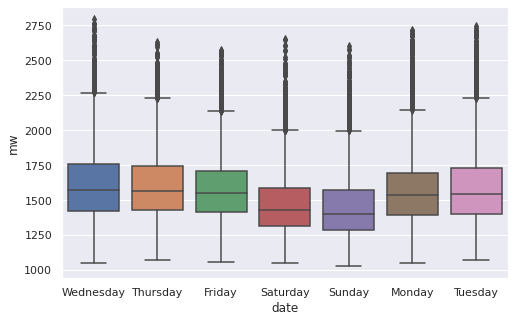

In [36]:
fig, axes = plt.subplots(1, 1, figsize=(8,5), sharex=True)
sns.boxplot(data=train, x=train.index.day_name(), y='mw')
fig.show()

#### 1.3.2 2018 Energy Consumption in One-Week of January:

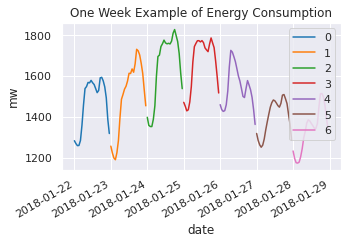

In [37]:
start, end = '2018-01-22', '2018-01-28'
one_week = train.loc[start:end]

fig, ax = plt.subplots(1,1, figsize=(5,3))
sns.lineplot(data=one_week, x=one_week.index, y='mw', palette='tab10',hue='weekday')
fig.autofmt_xdate()
ax.legend(loc=1)
ax.set(title='One Week Example of Energy Consumption')
fig.show()

Depends on the day of week, energy consumption changes. There are double peaks in each day in most days of the week. It is likely ude to less energy usage around the lunch time when a lot of poeple are out of the building.

### 1.4 Hourly Patterns

#### 1.4.1 2018 July - Hourly Energy Consumption in One-Day:

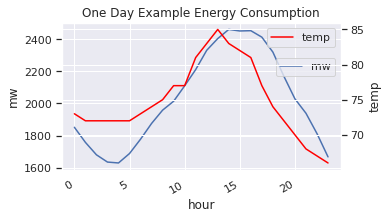

In [38]:
start, end = '2018-07-17', '2018-07-17'
one_day = train.loc[start:end]

fig, ax = plt.subplots(1,1, figsize=(5,3), sharex=True)
ax.set(title='One Day Example Energy Consumption')

g1 = sns.lineplot(data=one_day, x='hour', y='mw', label='mw')
ax2 = plt.twinx()
g2 = sns.lineplot(data=one_day, x='hour', y='temp', ax=ax2, color='red', label='temp')
sns.move_legend(g1, "upper right", bbox_to_anchor=(1., .8))
sns.move_legend(g2, "upper right", bbox_to_anchor=(1., 1))


fig.autofmt_xdate()


We think this is an **office building** because our energy consumption ramps up and ramps down around **business hours**.

#### 1.4.2 2018 January - Hourly Energy Consumption in One-Week:

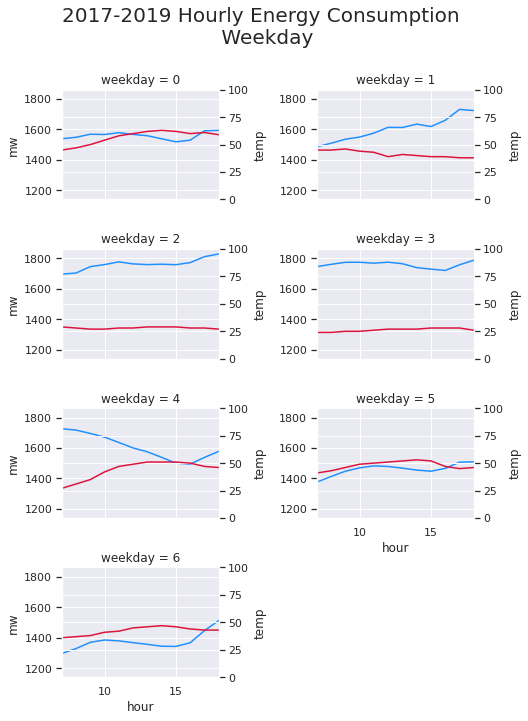

In [39]:
g = sns.relplot(data=one_week, x='hour', y='mw', col='weekday', col_wrap=2, kind='line', height=2.5, aspect=1.5, color='dodgerblue')

for weekday, ax in g.axes_dict.items():
    ax1 = ax.twinx()
    g1 = sns.lineplot(data=one_week[one_week['weekday'] == weekday], x='hour', y='temp', color='crimson', ax=ax1)
    g1.set(ylim=(0,100))
    g1.set(xlim=(7,18))
    
plt.suptitle('2017-2019 Hourly Energy Consumption \n Weekday', fontsize=20, y=1.)


g.tight_layout()
fig.show()

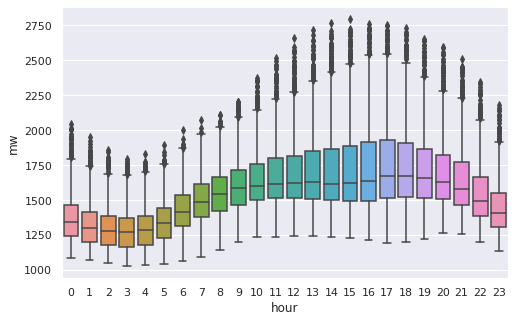

In [40]:
fig, axes = plt.subplots(1,1, figsize=(8,5), sharex=True)
sns.boxplot(data=train, x=train.hour, y='mw')
fig.show()

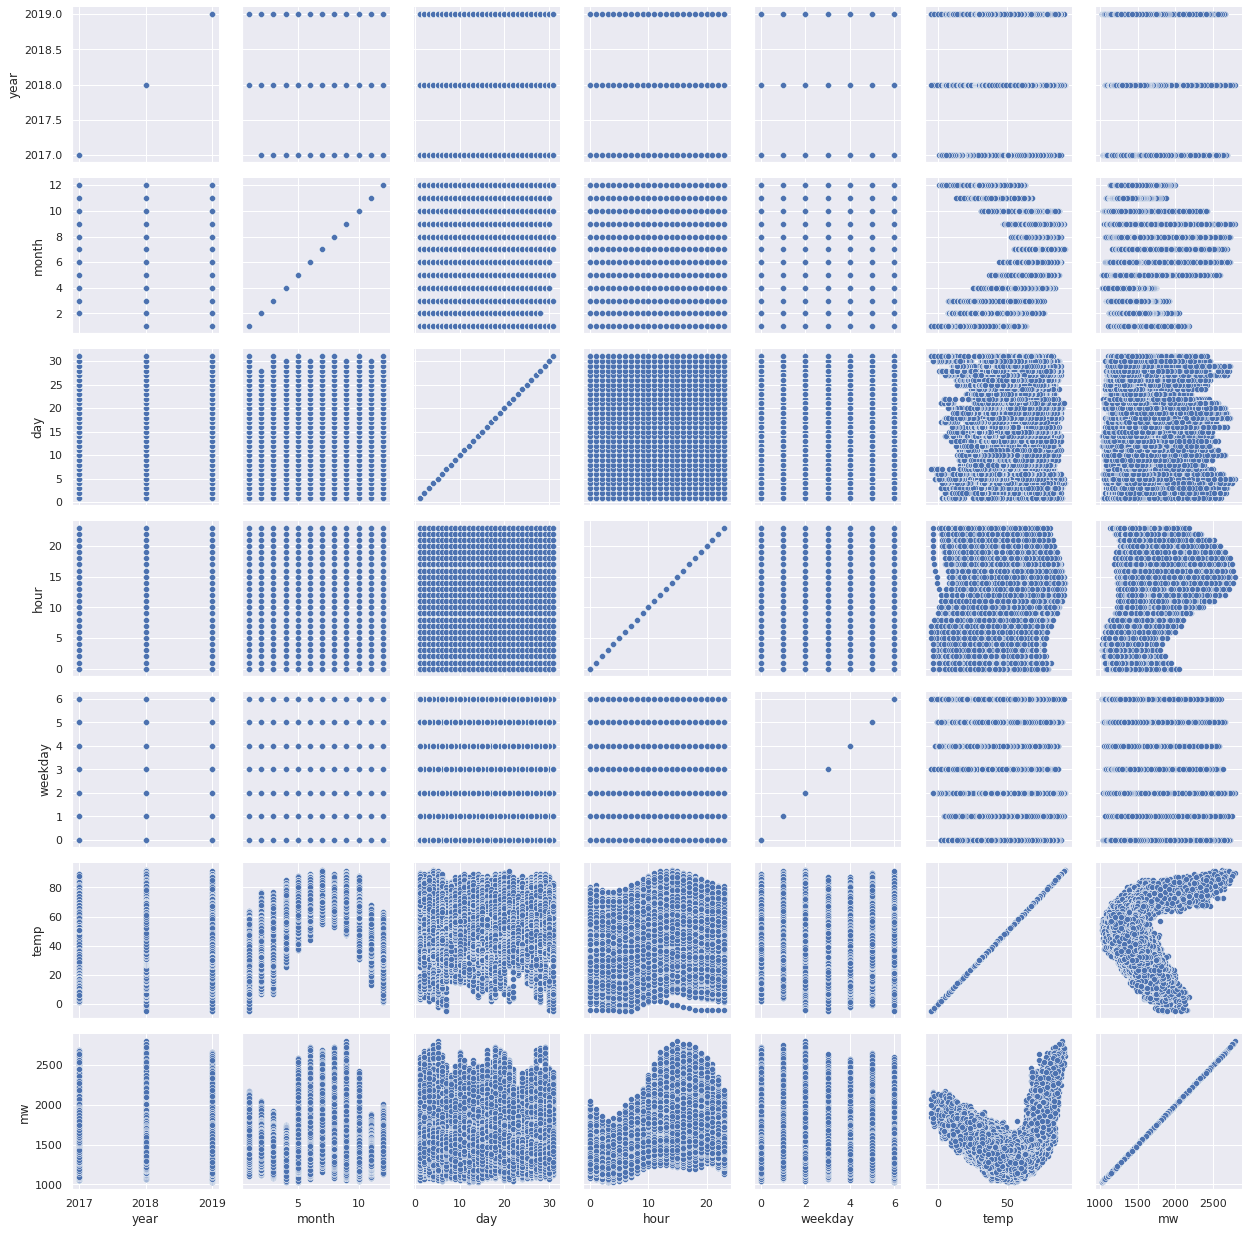

In [41]:
g = sns.PairGrid(train)
g.map(sns.scatterplot)

### 1.5 Resampling (Daily / Weekly / Monthly):

#### 1.5.1 Lower resolution to Daily Mean:

In [42]:
train_daily_mean = train.resample('D').mean()
print(train_daily_mean.shape[0])
train_daily_mean.head(3)

1064


,year,month,day,hour,weekday,temp,mw
date,,,,,,,
2017-02-01,2017.0,2.0,1.0,11.5,2.0,35.416667,1611.940083
2017-02-02,2017.0,2.0,2.0,11.5,3.0,30.375000,1623.083125
2017-02-03,2017.0,2.0,3.0,11.5,4.0,22.125000,1698.074250


#### 1.5.2 Lower resolution to Weekly Mean:

In [43]:
train_weekly_mean = train.resample('W').mean()
print(train_weekly_mean.shape[0])
train_weekly_mean.head(3)

153


,year,month,day,hour,weekday,temp,mw
date,,,,,,,
2017-02-05,2017.0,2.0,3.0,11.5,4.0,29.600000,1606.454000
2017-02-12,2017.0,2.0,9.0,11.5,3.0,39.607143,1531.264048
2017-02-19,2017.0,2.0,16.0,11.5,3.0,39.125000,1511.746649


#### 1.5.3 Lower resolution to Monthly Mean:

In [44]:
# compute the monthly sums, setting the value to NaN for any month wich has 
# fewer than 28 days of data
train_monthly_mean = train.resample('M').mean()
print(train_monthly_mean.shape[0])
train_monthly_mean.head(3)

35


,year,month,day,hour,weekday,temp,mw
date,,,,,,,
2017-02-28,2017.0,2.0,14.5,11.5,3.000000,41.363095,1505.044643
2017-03-31,2017.0,3.0,16.0,11.5,3.000000,40.377688,1490.788282
2017-04-30,2017.0,4.0,15.5,11.5,3.166667,57.861111,1363.225483


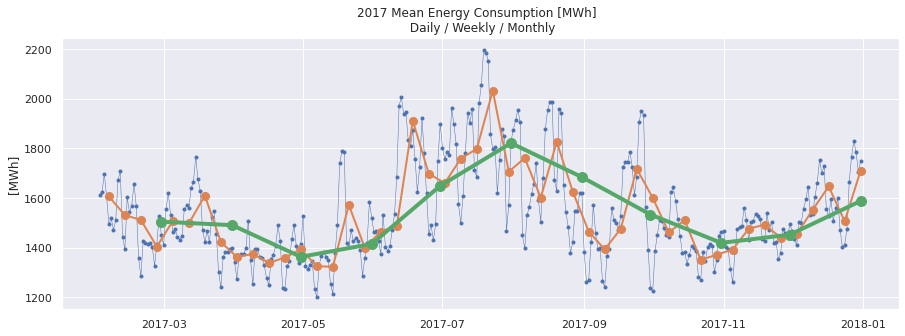

In [45]:
# start and end of the date range to extract
start, end = '2017-01', '2017-12'
# plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(train_daily_mean.loc[start:end, 'mw'], marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(train_weekly_mean.loc[start:end, 'mw'], marker='o', linestyle='-', markersize=8, label='Weekly', linewidth=2)
ax.plot(train_monthly_mean.loc[start:end, 'mw'], marker='o', linestyle='-', markersize=10, label='Monthly', linewidth=4)
ax.set(title='2017 Mean Energy Consumption [MWh]  \n Daily / Weekly / Monthly', ylabel='[MWh]')

fig.show()

### 1.6 Rolling Average

#### Trends
Time series data often exhibit some slow, gradual variability in addition to higher frequency variability such as seasonality and noise. An easy way to visualize these trends is with rolling means at different time scales.

A rolling mean trends to smmoth a time series by averaging out variabtions at much higher than the window size and averaging out any seasonality on a time scale equal to the window size. This allows lower-frequency variations in the data to be explored. Since our electricity consumption time series has weekly and yearly seasonality, let's look at rolling means on those two time scales.

In [46]:
# the min_periods=360 argument accounts for a few isolated missing days
# in the mw time series
train_24h = train.rolling(window=24, center=True, min_periods=20).mean()
train_7d = train_24h.rolling(window=168, center=True, min_periods=160).mean()
train_30d = train_24h.rolling(window=720, center=True, min_periods=700).mean()
train_365d = train_24h.rolling(window=8760, center=True, min_periods=8700).mean()

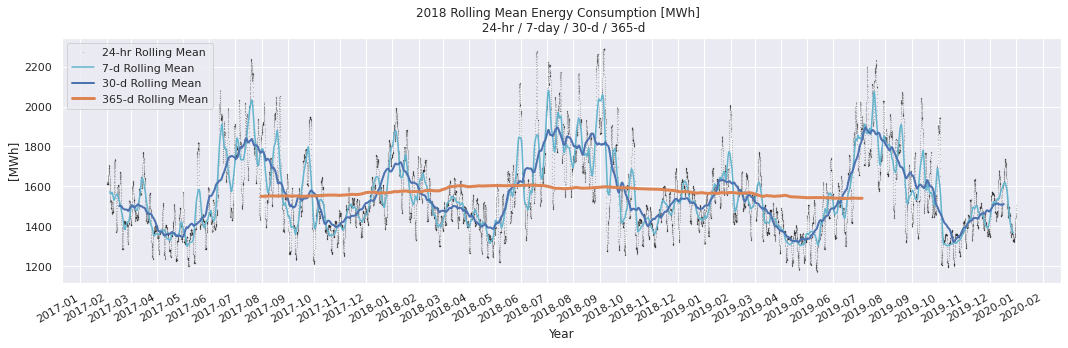

In [47]:
import matplotlib.dates as mdates

# plot 24-hr, 7-day rolling mean, and 30-day rolling mean time series
# start and end of the date range to extract
start, end = '2017-01', '2019-12'

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(train_24h.loc[start:end, 'mw'], marker='.', markersize=0.2, color='0.2', linestyle='None', label='24-hr Rolling Mean')
ax.plot(train_7d.loc[start:end, 'mw'], linewidth=1.5, color='c',label='7-d Rolling Mean')
ax.plot(train_30d.loc[start:end, 'mw'], linewidth=2,label='30-d Rolling Mean')
ax.plot(train_365d.loc[start:end, 'mw'], linewidth=3, label='365-d Rolling Mean')

#set x-ticks to yearly interval and add legend and labels
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Energy Consumption [MWh]')
ax.set_title('Trends in Energy Consumption')
ax.set(title='2018 Rolling Mean Energy Consumption [MWh]  \n 24-hr / 7-day / 30-d / 365-d', ylabel='[MWh]')

fig.autofmt_xdate()
fig.tight_layout()

We can see that the 7-day rolling mean has smoothed out all the weekly seasonality while preserving the yearly seasonality. In the same way, 364-day rolling mean has smoothed out all the yearly seasonality (no more spring, summer, fall, winter effect).

## Milestone 2 Remarks:
* From hourly energy usage pattern, we discovered that this is an office building operating at normal business hours.
* This building shows heating dominant (> cooling) energy consumption behaviour.
* We observed the seasonally changing relationship between temperature and energy consumption.
* We looked at linear correlation between variables.
* We looked at variance of temperature (hourly/monthly).
* We looked at variance of energy consumption (hourly/monthly).
* We removed hourly/weekly/monthly/yearly noise using rolling mean.
* Next, we need to look at non-linear relationship between variables.
* Now, we are ready to submit this assignment.

# Milestone 3 Objective:

* Linear regression model
* baseline vs improved models
* scikit-learn (Ridge Linear Regression)

In [48]:
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
import statsmodels.formula.api as smf
from scipy import stats

Notice how we added an addiitonal module above called statsmodels. We need to build regression models in this milestone and so we will need the statsmodels module to do so. Itis a Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration.

This milestone builds off the previous ones so we should complete the following steps to the first milestone again to hae our data prepped and ready to go!

<AxesSubplot:xlabel='date'>

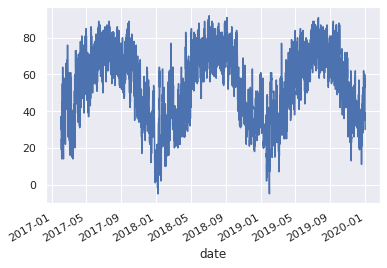

In [49]:
train.temp.plot()

## Z-transform (standardize)
* It is always good practice to standardize (mean of 0 and standard deviation of 1) 
* any variable we are goign to raise to raise to a higher power in a regression
* to help prevent multicollinearity problems
* we can standardize the variable 'temp'
* by using mean and std functions

In [50]:
mu = np.mean(train.temp)
std = np.std(train.temp)
print('mean_train:', round(mu,2))
print('std_train:', round(std,2))

mu = np.mean(test.temp)
std = np.std(test.temp)
print('\nmean_test:', round(mu,2))
print('std_test:', round(std,2))

mean_train: 53.44
std_train: 18.87

mean_test: 35.53
std_test: 10.39


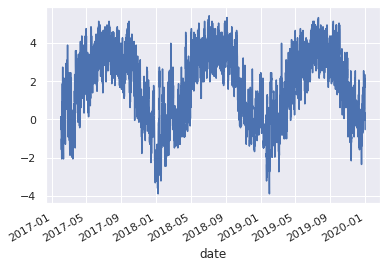

In [51]:
z_score = (train.temp - mu) / std
train['temp_norm'] = z_score
train.temp_norm.plot()
plt.show()

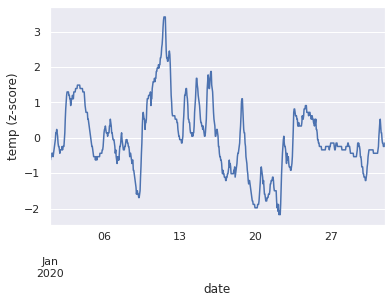

In [52]:
z_score = (test.temp - mu) / std
test['temp_norm'] = z_score
test.temp_norm.plot()
plt.ylabel('temp (z-score)')
plt.show()

Now that temperature is standardized (or normalized) we can just multiply it by itself to get out quadratic term.

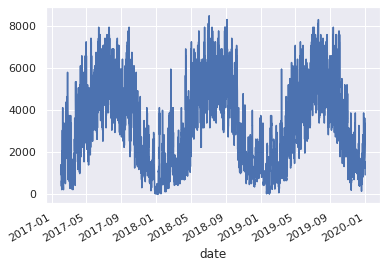

In [53]:
train['temp_norm2'] = train['temp']**2
train.temp_norm2.plot()
plt.show()

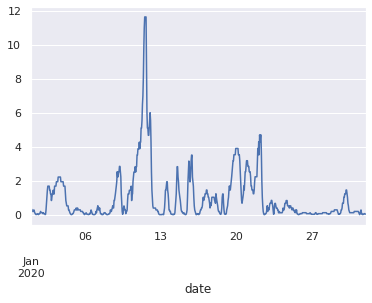

In [54]:
test['temp_norm2'] = z_score**2
test.temp_norm2.plot()
plt.show()

Let's do a brief look at the first few observations in our training / test data set to make sure that things worked as expected.

In [55]:
train.head()

,year,month,day,hour,weekday,temp,mw,temp_norm,temp_norm2
date,,,,,,,,,
2017-02-01 00:00:00,2017,2,1,0,2,37.0,1419.881,0.141799,1369.0
2017-02-01 01:00:00,2017,2,1,1,2,37.0,1379.505,0.141799,1369.0
2017-02-01 02:00:00,2017,2,1,2,2,36.0,1366.106,0.045541,1296.0
2017-02-01 03:00:00,2017,2,1,3,2,36.0,1364.453,0.045541,1296.0
2017-02-01 04:00:00,2017,2,1,4,2,36.0,1391.265,0.045541,1296.0


In [56]:
test.head()

,year,month,day,hour,weekday,temp,mw,temp_norm,temp_norm2
date,,,,,,,,,
2020-01-01 00:00:00,2020,1,1,0,2,31.0,1363.428,-0.435747,0.189876
2020-01-01 01:00:00,2020,1,1,1,2,29.0,1335.975,-0.628263,0.394714
2020-01-01 02:00:00,2020,1,1,2,2,30.0,1296.817,-0.532005,0.283029
2020-01-01 03:00:00,2020,1,1,3,2,30.0,1288.403,-0.532005,0.283029
2020-01-01 04:00:00,2020,1,1,4,2,31.0,1292.263,-0.435747,0.189876


Great! Now we have the foundation of building a model.

The naive energy model is just a linear regression model. It will use the terms that we already identified as potentially impacting the energy usage - hour of day, day of week, month of year, temperature, and temperature's quadratic term. The OLS.from_formula function in the statsmodels module will take care of this for us. We can then use the summary function to view our results.

Let's look at each feature individually for its impact on energy consumption.

In [57]:
features = train.columns.to_list()
features.pop(-4)
features.pop(-3)
features

['year', 'month', 'day', 'hour', 'weekday', 'temp_norm', 'temp_norm2']

In [58]:
#print('Parameters: ', result.params)
#print('Standard errors: ', result.bse)
#print('Predicted values: ', result.predict())
#https://www.statsmodels.org/0.6.1/examples/notebooks/generated/ols.html

intercept_col = []
coef_col = []
r2_col = []
se_col = []

for feature in features:
    result = sm.OLS.from_formula(f'mw ~ {feature}', data=train).fit()
    intercept, coef = result.params
    r2 = result.rsquared
    intercept1, se = result.bse
    
    intercept_col.append(intercept)
    coef_col.append(coef)
    r2_col.append(r2)
    se_col.append(se)

params_df = pd.DataFrame(columns=features,data=[intercept_col, coef_col, r2_col, se_col],index=['intercept','coefficient','r2', 'standard error'])
params_df = np.round(params_df,3)
params_df

,year,month,day,hour,weekday,temp_norm,temp_norm2
intercept,2788.857,1550.942,1569.380,1364.090,1626.402,1472.234,1346.293
coefficient,-0.609,1.381,-0.586,17.053,-22.072,50.993,0.067
r2,0.000,0.000,0.000,0.170,0.024,0.104,0.200
standard error,2.215,0.533,0.204,0.236,0.886,0.935,0.001


* r2: temp_norm2 > hour (this means temp_squared is a good predictor)
* Let's looks at temp_squared in more detail.

In [59]:
result = sm.OLS.from_formula('mw ~ temp_norm2', data=train).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                     mw   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     6377.
Date:                Mon, 18 Apr 2022   Prob (F-statistic):               0.00
Time:                        17:38:40   Log-Likelihood:            -1.7790e+05
No. Observations:               25539   AIC:                         3.558e+05
Df Residuals:                   25537   BIC:                         3.558e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1346.2929      3.122    431.179      0.0

Let's see what we have above in the results. First, our model summary is listed at the top. It reminds us what our target (dependent) variable is in our model which is energy usage. It also tells us how many observations it used to build the OLS linear regression model. On the right it provides some model evaluation metrics like R-squared, adjusted R-squared, log-likelihood, AIC, and BIC.

Adjusted R-squared is a common metric used. It is bounded above by 1 with the closer to 1 this is, the more variability in energy usage our model is able to explain.

Next, it provides a large table of results around each of the variables. For each variable, it provides the **coefficient** (think relationship) between that variable and energy usage. The **standard error** is the variability of this estimate. 

These two things together form the **t-test statistic** and **p-value** (the next two columns). The p-value tells you the chances that this variable is significant to predicting energy usage due to random chance. The lower this probability, the less likely we are to believe that our results are just lucky and we believe our variables are statistically significant at predicting energy usage.

From above, it looks like all the variables appear to statistically be related to energy. Our model is off to a great start! Let's try to add additional terms to our model to improve it.

In [60]:
result = sm.OLS.from_formula('mw ~ temp + temp_norm2 + C(hour) + C(month) + C(weekday)', data=train).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                     mw   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     2770.
Date:                Mon, 18 Apr 2022   Prob (F-statistic):               0.00
Time:                        17:38:41   Log-Likelihood:            -1.5883e+05
No. Observations:               25539   AIC:                         3.178e+05
Df Residuals:                   25496   BIC:                         3.181e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        2139.3342      6.764    3

Our prediction has greatly improved with additional variables!

We already checked if month and temperature have separate impacts on energy usage. However, from the plots we saw earlier, we also hypothesized that the effect of temperature was different in different months. Let's try to visualize that here. The following code highlights the months of January and July in our previous temperature by energy usage scatter plot.

### January Prediction (on Training Data):

In [61]:
data = train.loc[train.month == 1]
result = sm.OLS.from_formula('mw ~ temp_norm + temp_norm2 + C(hour) + C(month) + C(weekday)', data=data).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                     mw   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     358.8
Date:                Mon, 18 Apr 2022   Prob (F-statistic):               0.00
Time:                        17:38:43   Log-Likelihood:                -8441.4
No. Observations:                1488   AIC:                         1.695e+04
Df Residuals:                    1456   BIC:                         1.712e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1278.9011     14.691     

### July Prediction (on Training Data):

In [62]:
data = train.loc[train.month == 7]
result = sm.OLS.from_formula('mw ~ temp_norm + temp_norm2 + C(hour) + C(month) + C(weekday)', data=data).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                     mw   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     636.9
Date:                Mon, 18 Apr 2022   Prob (F-statistic):               0.00
Time:                        17:38:44   Log-Likelihood:                -13713.
No. Observations:                2232   AIC:                         2.749e+04
Df Residuals:                    2200   BIC:                         2.767e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         597.2264     23.279     

What does this show us? It shows exactly what we saw in milestone 2! It looks like in July, temperautre has a different relationship with energy than in January. This different relationship is called an interaction. Luckily these can easily be added into models. Let's check if the same phenomenon exists across different hours. The following highlights the hours of midnight and noon for our temperature by energy scatter plot.

### Midnight Prediction (on Training Data):

In [63]:
data = train.loc[train.hour == 0]
result = sm.OLS.from_formula('mw ~ temp_norm + temp_norm2 + C(hour) + C(month) + C(weekday)', data=data).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                     mw   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     182.4
Date:                Mon, 18 Apr 2022   Prob (F-statistic):          2.32e-315
Time:                        17:38:45   Log-Likelihood:                -6230.0
No. Observations:                1064   AIC:                         1.250e+04
Df Residuals:                    1044   BIC:                         1.260e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         761.7170     21.473     

### Noon Prediction (on Training Data)

In [64]:
data = train.loc[train.hour == 14]
result = sm.OLS.from_formula('mw ~ temp_norm + temp_norm2 + C(hour) + C(month) + C(weekday)', data=data).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                     mw   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     260.2
Date:                Mon, 18 Apr 2022   Prob (F-statistic):               0.00
Time:                        17:38:46   Log-Likelihood:                -6692.8
No. Observations:                1064   AIC:                         1.343e+04
Df Residuals:                    1044   BIC:                         1.352e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1001.8311     28.089     

Again, it looks like some differences are occuring. Not surprisingly, people react more to temperature changes when they are awake as copared to when they are asleep. Let's incorporate these interactions with temperature (and its quadratic term) with hour and month. Also, in milestone 2, we noticed that hours were different on weekends compared to weekdays for energy usage so let's also interact hour and weekday.

All of those terms appeared significant too! Execellent. Now we have our naive energy model. It takes into account the hour of day, day of week, month of year, and the complicated relationship with temperature.

Time to see how good our predictions are. One evaluation of model performance is the mean absolute precentage (MAPE). This evaluateson average how far off are our predictions in terms of percentages. We need to get our predictions from our training data set. The fittedvalues function will do that for us. Then we can calculate the MAPE ourselves. 

In [65]:
result = sm.OLS.from_formula('mw ~ temp_norm*C(hour) + temp_norm2*C(hour) + \
                            temp_norm*C(month) + temp_norm2*C(month) + \
                            C(weekday)*C(hour) + C(month)*C(weekday) + \
                            C(hour)*C(month) \
                             ', 
                              data=train).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                     mw   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     519.9
Date:                Mon, 18 Apr 2022   Prob (F-statistic):               0.00
Time:                        17:38:51   Log-Likelihood:            -1.4819e+05
No. Observations:               25539   AIC:                         2.975e+05
Df Residuals:                   24971   BIC:                         3.021e+05
Df Model:                         567                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

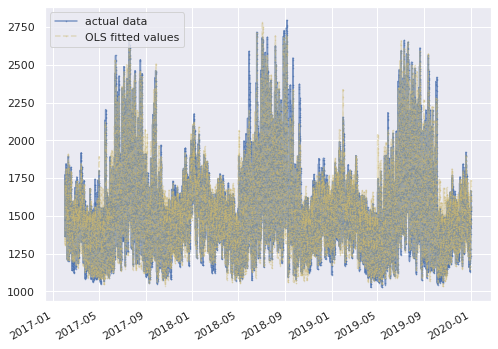

In [66]:
x = train.index
y = train.mw
y_fitted = result.fittedvalues

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, y, '.-', label="actual data", alpha=0.7, markersize=1)
ax.plot(x, y_fitted, '.y--', label="OLS fitted values", alpha=0.4, markersize=1,)
ax.legend(loc='best');
fig.autofmt_xdate()

A good evaluation of a model is mean absolute percentage error (MAPE). This is because we want to evaluate on average how far off our predictions are in terms of percentages. The MAPE is calculated as:

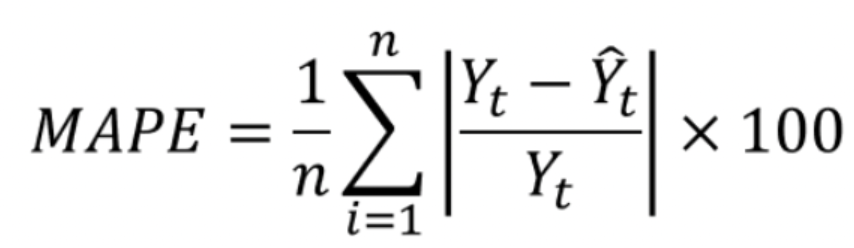

In [67]:
train['fitted'] = result.fittedvalues
ape = abs((train.mw - train.fitted)/train.mw) * 100
mape = ape.mean()
print(f'MAPE for training dataset: {round(mape,2)} %')

MAPE for training dataset: 3.46 %


In [68]:
train.head(3)

,year,month,day,hour,weekday,temp,mw,temp_norm,temp_norm2,fitted
date,,,,,,,,,,
2017-02-01 00:00:00,2017,2,1,0,2,37.0,1419.881,0.141799,1369.0,1346.692695
2017-02-01 01:00:00,2017,2,1,1,2,37.0,1379.505,0.141799,1369.0,1313.429622
2017-02-01 02:00:00,2017,2,1,2,2,36.0,1366.106,0.045541,1296.0,1309.580574


We are worried only about short-term forecasts for possible immediate energy needs. Let's "Forecast" out our model by scoring our test dataset with the linear regression we built. Remember, we don't want to build a model on the test dataset. Just run the observations through the equation we got from the training model. 

### 2020 January Prediction (on Test Data):

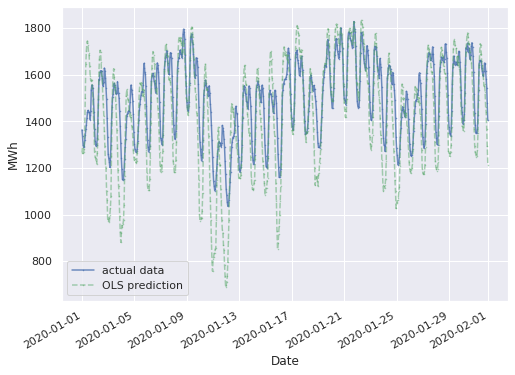

In [69]:
test['pred'] = result.predict(test)
x = test.index
y = test.mw
y_pred = test.pred

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, y, '.-', label="actual data", alpha=0.8, markersize=1)
ax.plot(x, y_pred, '.g--', label="OLS prediction", alpha=0.5, markersize=1,)
plt.xlabel('Date')
plt.ylabel('MWh')
ax.legend(loc='best');
fig.autofmt_xdate()

In [70]:
test.head(3)

,year,month,day,hour,weekday,temp,mw,temp_norm,temp_norm2,pred
date,,,,,,,,,,
2020-01-01 00:00:00,2020,1,1,0,2,31.0,1363.428,-0.435747,0.189876,1266.012394
2020-01-01 01:00:00,2020,1,1,1,2,29.0,1335.975,-0.628263,0.394714,1284.364079
2020-01-01 02:00:00,2020,1,1,2,2,30.0,1296.817,-0.532005,0.283029,1262.892718


 Those look like rather good predictions! Let's see what the MAPE is on these.

In [71]:
test['pred'] = result.predict(test)
ape = abs((test.mw - test.pred)/test.mw) * 100
mape = ape.mean()
print(f'MAPE for test dataset: {round(mape,2)} %')

MAPE for test dataset: 7.74 %


Great! Remember, the MAPE is probably going to be higher becasue our model hasn't seen this data before. this is a great way to truly evaluate how well our model will do when deployed in a real world setting since we won't know energy data before we predict it. Looks like our model is off by 7.74% on average.

The foundation is laid in this step. Model building can be complicated and sometimes it is hard to know when to stop. The best plan is to build a foundational model that we can try to build upon and/or outperform with later editions of our model. Without a good baseline, we won't know how good your final model is. These seasonal effects of hours of day, days of week, months of year as well as the temperature effects build a great first attempt at forecasting future energy usage.

This is a great initial model if our boss needs a check-in to see our progress. this model gets us a long way there since we have incorporated temperature's complicated relationship. In the next milestones, we get to build on this great foundation to really show our boss what we can do!